**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- matrix profile and anomaly detection,
- change point detection,
- graph signal processing. 


## Setup

**Imports**

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.spatial.distance import pdist, squareform



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind

import re
from math import asin, cos, radians, sin, sqrt

import contextily as cx
import geopandas
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.dates import DateFormatter
from pygsp import graphs
from scipy.linalg import eigh


**Utility functions** 

In [128]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

try:
    from numpy.lib.stride_tricks import sliding_window_view  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]

except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )

def fill_band(array2D: np.ndarray, width: int = 1, value=0) -> np.ndarray:
    """Fill thick diagonal band of a matrix with value"""
    n_rows, n_cols = array2D.shape
    distance_from_diag = np.abs(np.add.outer(np.arange(n_rows), -np.arange(n_cols)))
    array2D[distance_from_diag <= width] = value
    return array2D


myFmt = DateFormatter("%H:%M")

def plot_clinear_approx(time_index, signal, bkps, ax=None):
    # plot
    ax.plot(time_index, signal)
    # plot changes
    for b in bkps[:-1]:
        ax.axvline(time_index[b], ls="--", color="k")
    # add linear approximation
    indexes = np.r_[0, np.array(bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="k",
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="r",
        alpha=0.5,
        s=100,
        marker="*",
    )
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(myFmt)



## 1. Matrix profile and anomaly detection.

At the end of the last tutorial we saw some techniques to detect isolated outliers, but in some cases anomalies span an entire time window, whose behaviour deviates from the rest of the signal.

Informally, such an outlier is a motif that only appears once a signal.
The distance of this particular pattern from all other patterns is large.

Algorithmically:

- Extract the trajectory matrix.
- Compute the pairwise distances between all patterns.
- Set to Inf the distance between patterns that overlap.
- Take the minimum pairwise distance for each pattern (the profile)


Then we apply outlier detection on the profile.

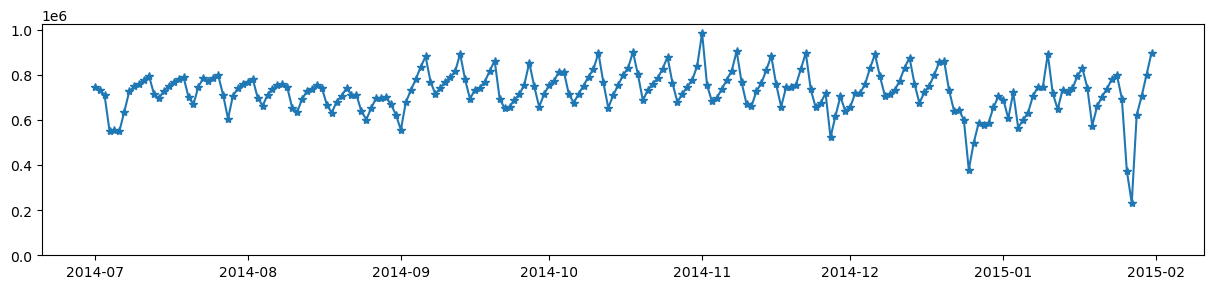

In [129]:
#we use the same dataset as in the previous notebook

X=pd.read_csv('nyc_taxi.csv')
X["timestamp"] = pd.to_datetime(X["timestamp"])

daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
calendar_time_array = daily_taxi_count.index.to_numpy()
n_samples = daily_taxi_count_np.size
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

In [130]:
window_shape = 7
quantile_threshold_high = 0.95

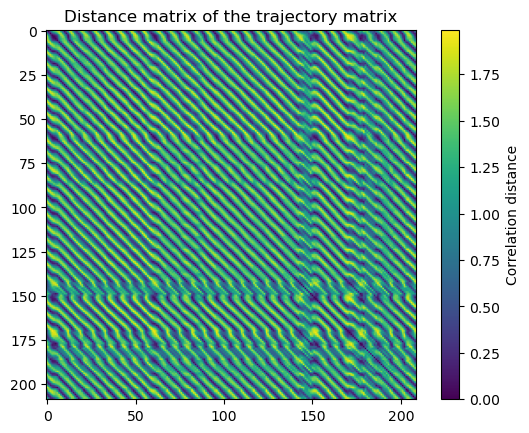

In [131]:
# extract the trajectory matrix
trajectory_matrix = get_trajectory_matrix(
    arr=daily_taxi_count_np, window_shape=window_shape
)

# compute distance matrix
distance_matrix = squareform(pdist(trajectory_matrix, metric="correlation"))
plt.imshow(distance_matrix)
plt.colorbar(label="Correlation distance")
plt.title("Distance matrix of the trajectory matrix")
plt.show()

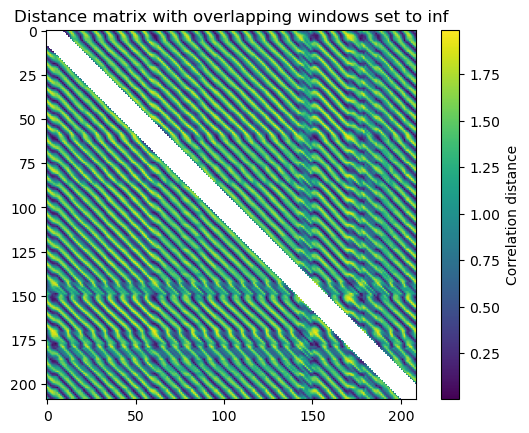

In [132]:
# set to inf the overlapping windows
distance_matrix = fill_band(distance_matrix, window_shape, np.inf)
plt.imshow(distance_matrix)
plt.colorbar(label="Correlation distance")
plt.title("Distance matrix with overlapping windows set to inf")
plt.show()

In [133]:
# compute profile
distance_profile = distance_matrix.min(axis=1)
indices_profile = distance_matrix.argmin(axis=1)

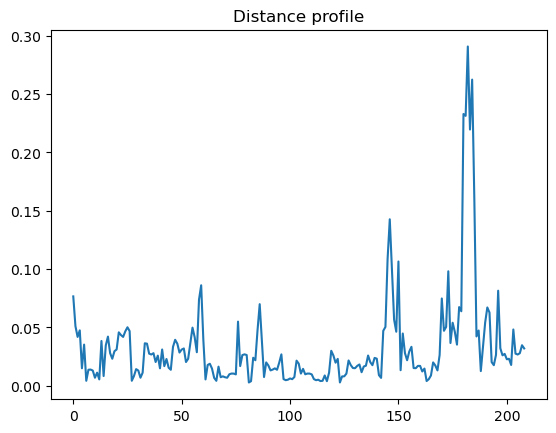

In [134]:
plt.plot(distance_profile)
plt.title("Distance profile")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the Matrix Profile and the Matrix Profile Index, identify: (1) the two most similar non-overlapping subsequences (the 1-Pair Motif), and (2) the subsequence with the largest Matrix Profile value (the Discord). Then, plot these subsequences on the full time series.</p>
</div>

In [ ]:
i = ...
j = ...
k = ...


time_index = daily_taxi_count.index

fig, ax = fig_ax()
ax.plot(time_index, daily_taxi_count, color="black", linewidth=1)
ax.set_ylim(0)

# --- Motif at i ---
ax.plot(
    time_index[i:i+window_shape],
    daily_taxi_count[i:i+window_shape],
    color="tab:blue", linewidth=3,
    label=f"Motif subsequence at i={time_index[i].date()}"
)

# --- Motif at j ---
ax.plot(
    time_index[j:j+window_shape],
    daily_taxi_count[j:j+window_shape],
    color="tab:blue", linewidth=3,
    label=f"Motif subsequence at j={time_index[j].date()}"
)

# --- Discord at k ---
ax.plot(
    time_index[k:k+window_shape],
    daily_taxi_count[k:k+window_shape],
    color="tab:red", linewidth=3,
    label=f"Discord subsequence at k={time_index[k].date()}"
)

ax.legend()
ax.set_title("Motif (i, j) and Discord (k) highlighted on the full time series")


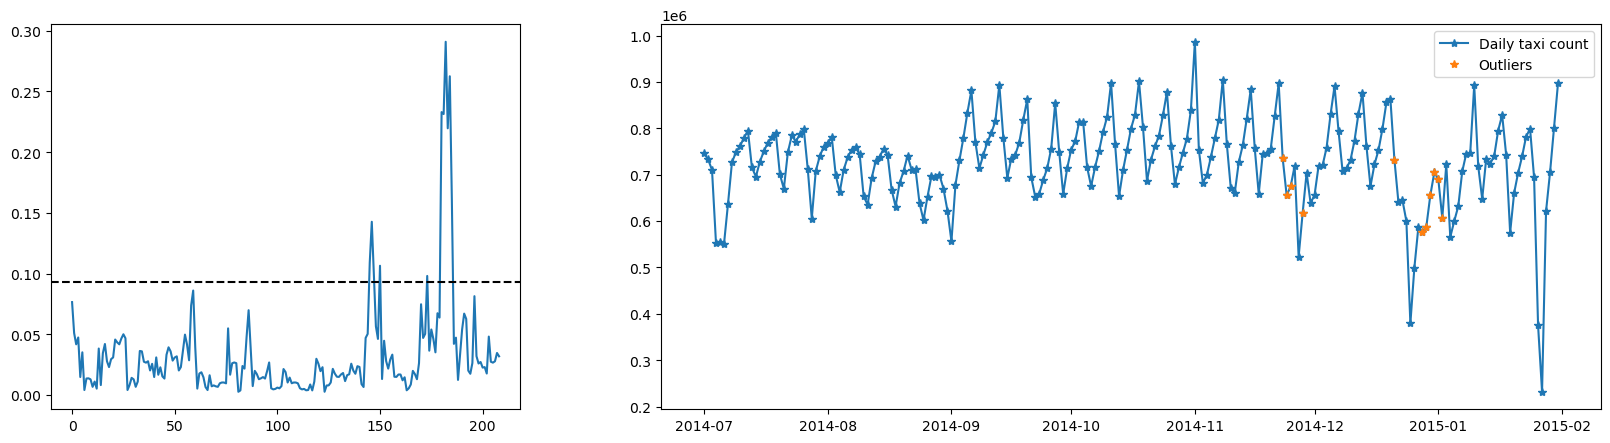

In [135]:
# we can set a threshold to detect all the anomalies.

# get threshold
threshold_high = np.quantile(distance_profile, quantile_threshold_high)

# plot results
fig, (ax_0, ax_1) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1, 2]}, figsize=(20, 5)
)

ax_0.plot(distance_profile)
ax_0.axhline(threshold_high, ls="--", color="k")

ax_1.plot(calendar_time_array, daily_taxi_count_np, "*-", label="Daily taxi count")
outlier_mask = distance_profile > threshold_high
offset = window_shape - 1
ax_1.plot(
    calendar_time_array[:-offset][outlier_mask],
    daily_taxi_count_np[:-offset][outlier_mask],
    "*",
    label="Outliers",
)
_ = plt.legend()

## 2. Change Point Detection

Change point detection consists in finding the temporal boundaries of homogeneous portions of a signal.

### Mean shift detection

The simplest (and oldest) change point detection methods deals with mean shifts.

#### Single change point

We start by trying to detect a single shift in mean (in a synthetic signal).

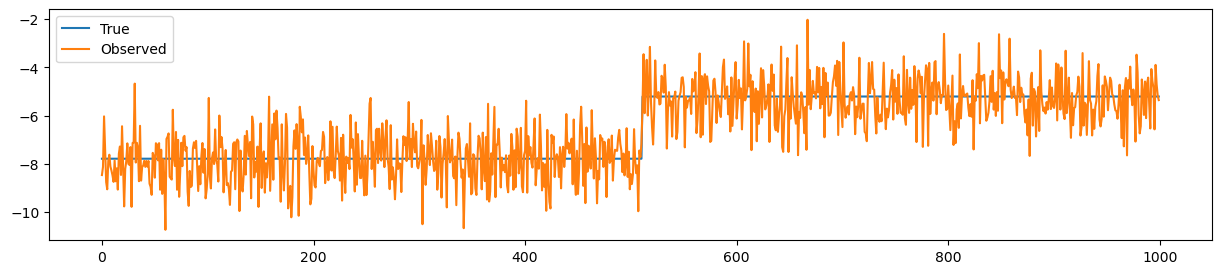

In [136]:
# generate signal
n_samples = 1000
n_bkps = 1
n_dims = 1
sigma_noise = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(scale=sigma_noise, size=signal.shape)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()

We fit the noisy signal with a piecewise constant function with a single discontinuity. The best fit is the function which minimizes the norm of the residuals.

For a $T$-sample signal $y$ and an index $a$, this amounts to:

$$
\sum_{t< a} \|y_t-\bar{y}_{0..a}\|^2 + \sum_{t\geq a} \|y_t-\bar{y}_{a..T}\|^2
$$

where $\bar{y}_{0..a}$ and $\bar{y}_{a..T}$ are the empirical means of $\{y_0,\dots,y_{a-1}\}$ and $\{y_a,\dots,y_{T-1}\}$ respectively.

The detection procedure consists in finding the index $a$ that minimizes this sum of costs.

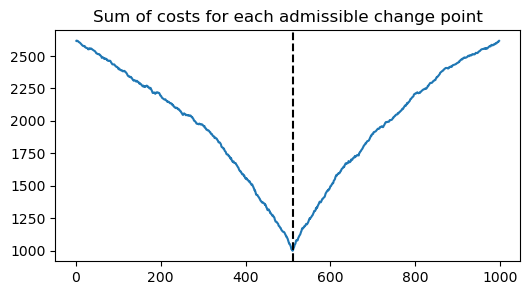

In [138]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[:mid_point].var() * mid_point + signal_with_noise[
        mid_point:
    ].var() * (n_samples - mid_point)
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")
ax.set_title("Sum of costs for each admissible change point")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens to the sum of costs when the noise varies?</p>
    <p>And when the number of samples increases?</p>
</div>

To check if a change point is indeed present, let us do a t-test between the left part of the signal and the right part of the signal.

In [139]:
ttest_ind(
    signal_with_noise[:detected_change_point],
    signal_with_noise[detected_change_point:],
)

TtestResult(statistic=array([-40.19897529]), pvalue=array([6.9278825e-211]), df=array([998.]))

At first sight, the detected change seems to be statistically significant.


However, let us test this procedure on a pure noise signal.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Perform the same procedure as before on the pure noise signal. According to the t-test, is there a change point?</p>
    <p>What went wrong?</p>
</div>

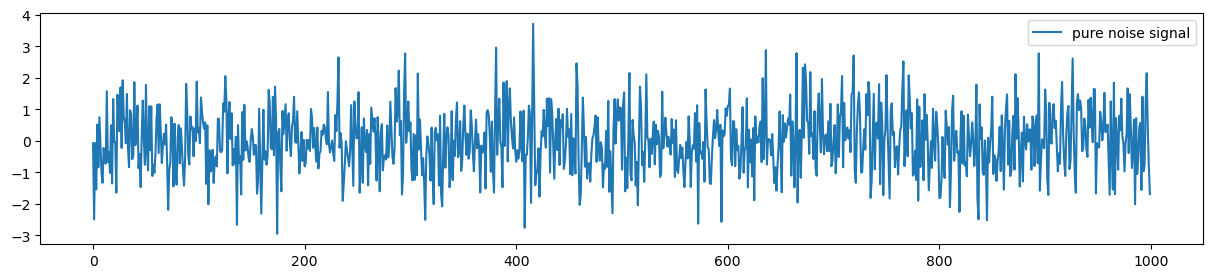

In [146]:
n_samples = 1000
pure_noise = np.random.normal(scale=sigma_noise, size=n_samples)
fig, ax = fig_ax()
ax.plot(pure_noise, label="pure noise signal")
_ = plt.legend()

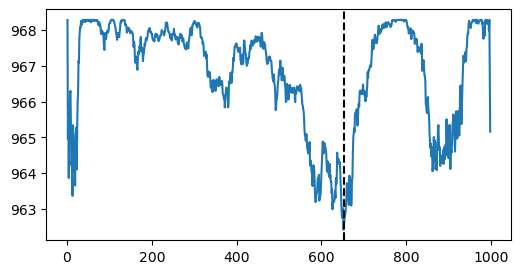

In [147]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = pure_noise[:mid_point].var() * mid_point + pure_noise[
        mid_point:
    ].var() * (n_samples - mid_point)
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

In [148]:
ttest_ind(
    pure_noise[:detected_change_point],
    pure_noise[detected_change_point:],
)

TtestResult(statistic=-2.467939046463635, pvalue=0.013756136213729798, df=998.0)

#### Multiple change points (known $K$)

To extend the detection to more than one change, we simply sum the costs of each segment defined by the $K$ change points $t_1,\dots,t_K$:

$$
\sum_{t=0}^{t_1-1} \|y_t-\bar{y}_{0..t_1}\|^2 + \sum_{t=t_1}^{t_2-1} \|y_t-\bar{y}_{t_1..t_2}\|^2 + \dots + \sum_{t=t_K}^{T-1} \|y_t-\bar{y}_{t_K..T}\|^2.
$$

We minimize over the $t_k$, using dynamic programming. (Other methods exists, e.g. binary segmentation, bottom-up, window-based, but are only approximate.)

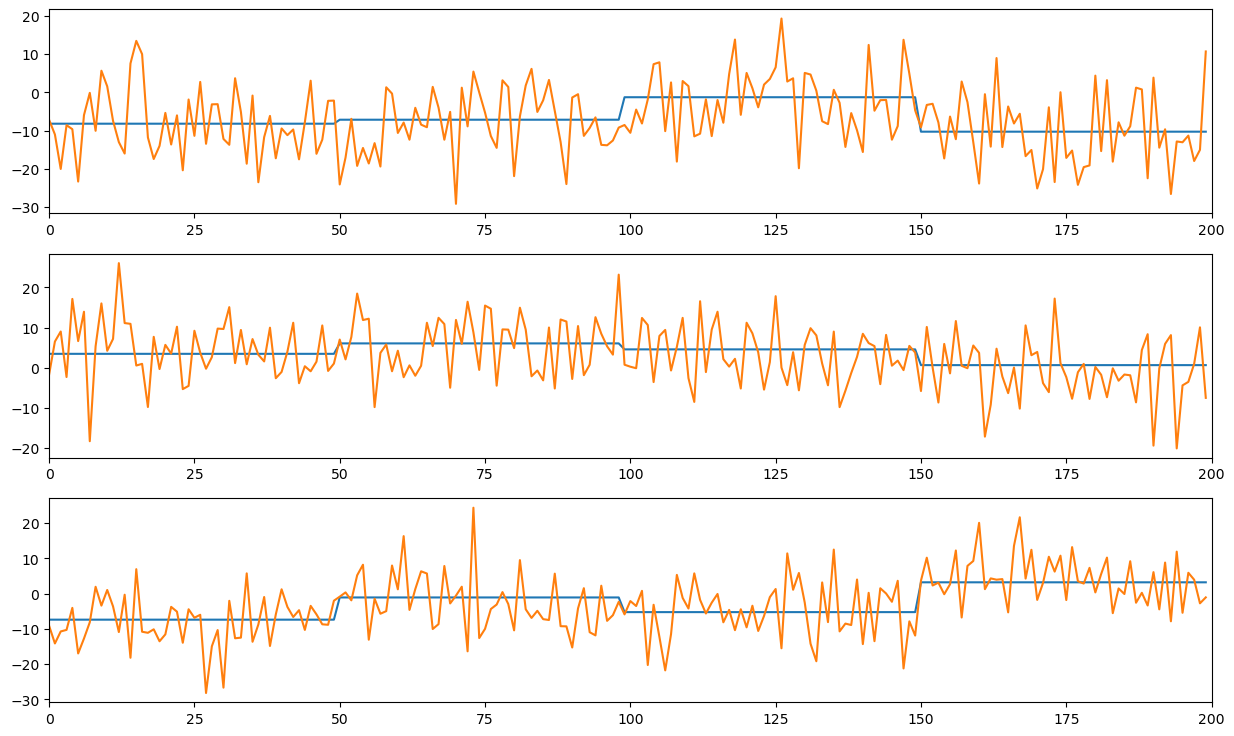

In [196]:
# generate signal
n_samples = 200
n_bkps = 3
n_dims = 3
sigma_noise = 8
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(scale=sigma_noise, size=signal.shape)

# display
fig, ax_arr = fig_ax(nrows=n_dims)
for signal1d, signal1d_with_noise, ax in zip(signal.T, signal_with_noise.T, ax_arr):
    ax.plot(signal1d)
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

Perform change point detection using dynamic programming.

In [197]:
algo = rpt.Dynp(model="l2", jump=1).fit(signal_with_noise)

error: 4.0 samples


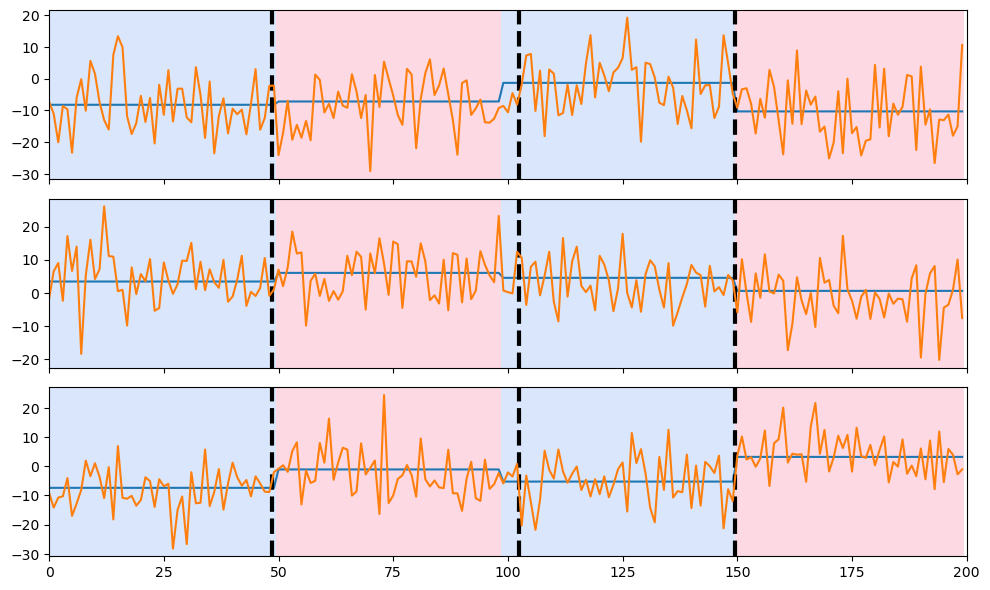

In [198]:
predicted_bkps = algo.predict(n_bkps=n_bkps)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for signal1d_with_noise, ax in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

#### Penalized change point detection (unknown $K$)

When the number of changes $K$ is unknown, we can perform penalized detection:

$$
\min_{K, t_1,\dots,t_K} \left[ \left(\sum_k \sum_{t=t_k}^{t_{k+1}-1} \|y_t-\bar{y}_{t_k..t_{k+1}}\|^2 \right) + \beta K \right]
$$

when $\beta>0$ controls the trade-off between the data fidelity and the complexity of the segmentation.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>When the regularization parameter increases, do we detect more or less changes?</p>
</div>

This formulation generalizes a number of model selection criterion, for instance the well-known BIC criterion: $\beta_{\text{BIC}}=2\sigma^2\log(T)$ (where $T$ is the number of samples) for a univariate Gaussian process with piecewise constant mean and *known* variance.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a piecewise constant univariate signal with Gaussian noise, use BIC (with one and zero change) to asses the presence of a change.</p>
</div>

Let us apply the BIC criterion on a signal with several changes.

In [202]:
# generate signal
n_samples = 1000
n_bkps = 7
n_dims = 1
noise_std = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=noise_std
)

Penalized change point detection is performed with PELT.

error: 0.0 samples


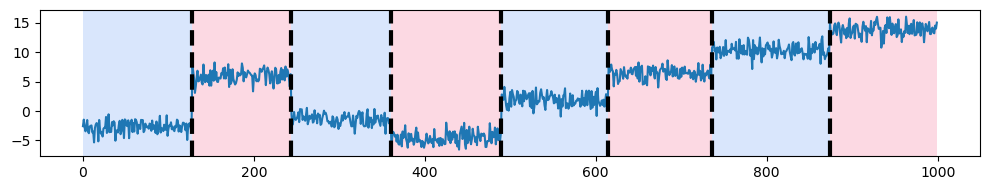

In [203]:
pen_bic = 2 * np.log(n_samples) * noise_std**2
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal, pen=pen_bic)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

### General distribution change (parametric)

By setting the cost function to the negative max log likelihood, we can detect any (parametric) distribution change.

$$
c(y_{a..b}) = - 2 \max_\theta\log L(y_{a..b}, \theta)
$$

where $L(\cdot, \theta)$ is the likelihood of a distribution parametrized by $\theta$.

#### Multivariate Gaussian

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Assume a multivariate Gaussian process with piecewise constant parameters (mean and covariance matrix). Derive the associated cost function and BIC penalty.</p>
</div>

### Count data (Poisson)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Assume a Poisson process with piecewise constant rate parameter. Derive the associated cost function and BIC penalty.</p>
</div>

We can define a cost function that can be used in `Dynp` and `Pelt`.

In [204]:
class PoissonCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        #YOUR CODE 
        return val

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect the change-points in the following signal (assume that the number of changes is unknown).</p>
</div>

In [205]:
# fmt: off
pwc_poisson_signal = np.array([16,14,9,11,10,19,7,13,18,10,15,15,6,21,15,13,15,16,14,11,11,11,16,15,10,13,5,13,11,10,17,17,14,16,9,10,9,14,14,9,4,17,10,15,19,14,18,11,11,14,11,6,15,16,15,15,12,9,16,14,12,13,10,13,19,12,14,15,16,14,10,10,13,13,17,9,9,9,16,6,7,9,11,13,23,10,9,9,18,19,15,5,14,14,7,8,22,13,13,7,14,11,8,11,18,9,9,20,10,9,14,16,9,8,8,19,14,16,9,11,15,13,14,10,14,15,15,16,9,10,6,5,12,6,10,10,5,11,13,9,9,10,11,12,14,11,9,9,11,10,7,11,6,10,13,9,5,13,13,6,8,8,6,10,14,15,8,21,10,7,12,14,11,15,11,11,13,9,11,11,14,9,10,10,9,10,9,6,8,7,12,10,15,6,8,10,9,9,17,8,9,6,5,15,3,12,10,11,11,8,7,9,9,10,11,10,8,15,9,12,5,8,13,12,9,12,5,13,13,9,13,9,9,11,11,15,12,11,6,9,9,2,8,17,13,5,13,10,6,9,14,9,13,12,10,9,15,13,18,7,10,7,15,17,10,15,19,11,10,15,16,12,13,15,11,11,7,11,9,11,8,10,11,19,14,18,12,18,13,9,13,12,7,12,11,15,10,17,14,9,16,19,11,11,21,12,13,19,12,11,15,16,11,14,17,12,17,16,13,11,7,21,16,13,11,13,9,13,6,15,21,10,17,8,14,11,12,17,11,12,8,16,20,10,6,13,11,14,7,10,9,8,9,19,16,17,10,11,14,6,12,16,12,18,11,16,12,6,16,11,18,12,14,12,16,14,16,14,14,19,6,12,10,25,11,16,17,16,12,9,14,14,10,15,12,17,13,16,17,13,9,22,25,20,16,14,20,15,16,14,21,15,11,14,18,11,17,19,10,17,17,9,18,12,10,10,10,19,15,25,13,20,22,17,14,12,11,13,23,17,18,19,19,9,8,16,16,20,21,23,16,17,15,17,9,19,12,18,21,17,15,17,18,17,19,20,18,9,9,18,17,12,16,14,20,11,16,13,19,16,14,16,15,17,15,19,11,17,17,14,13,10,14,13,17,15,14,14,16,26])
# fmt: on
bkps = [128, 252, 377, 500]

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are known limitations of the BIC criterion?</p>
</div>

## Experiments

In [208]:
dataset_name = "DodgerLoopGame"
data = load_uea_ucr_data(dataset_name)

indexes_with_nan = [7, 15, 19]
X_train = np.delete(data.X_train.data, indexes_with_nan, axis=0)
y_train = np.delete(data.y_train.data, indexes_with_nan, axis=0)

print(data.description)

# DodgersLoop dataset

The traffic data are collected with the loop sensor installed on ramp for the 101 North freeway in Los Angeles. This location is close to Dodgers Stadium; therefore the traffic is affected by volumne of visitors to the stadium.

We make three datasets out of these data.

## DodgersLoopDay

The classes are days of the week.

- Class 1: Sunday
- Class 2: Monday
- Class 3: Tuesday
- Class 4: Wednesday
- Class 5: Thursday 
- Class 6: Friday
- Class 7: Saturday 

Train size: 78

Test size: 80

Number of classes: 7

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopWeekend

- Class 1: Weekday
- Class 2: Weekend

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopGame

- Class 1: Normal day
- Class 2: Game day

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

There is 

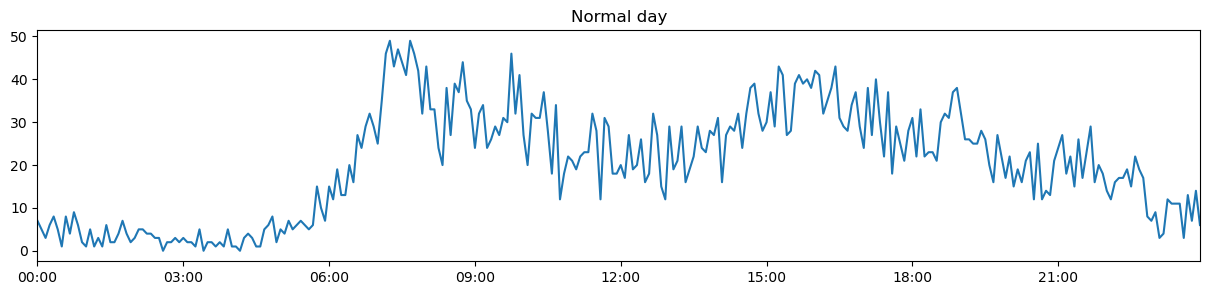

In [210]:
ind = 8

signal = X_train[ind]
label = int(y_train[ind])

time_index = pd.date_range("00:00", "23:59", freq="5min")

fig, ax = fig_ax()
ax.plot(time_index, signal)
ax.xaxis.set_major_formatter(myFmt)
ax.margins(x=0)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

### Change in the intensity of a Poisson distribution

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect changes in the Poisson rate parameter, with the BIC criterion.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe?</p>
</div>

### Piecewise linear approximation

Instead we can use a piecewise linear approximation with continuity constraint (cost function `clinear`).

In [ ]:
fig, ax = fig_ax()

detected_bkps = rpt.Dynp(model="clinear").fit(signal).predict(n_bkps=3)
plot_clinear_approx(time_index=time_index, signal=signal, bkps=detected_bkps, ax=ax)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

The associated BIC criterion is $\beta_{\text{clinear}, BIC} = 2\sigma^2\log(T)$.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>The PELT algorithm does not work with the continuous piecewise linear model. Code a function to compute the penalized segmentation with this model. You can assume that Kmax=15.</p>
    <p>Detect changes with the BIC criterion. (Use the first 50 samples to estimate the variance.)</p>

</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you think of this segmentation?</p>
</div>

# 3. Graph Signal

In [211]:
CRS = "EPSG:4326"

STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

In [212]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g

def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Graph signal processing

A graph $G$ is a set of $N$ **nodes** connected with **edges**. A **graph signal** is a $\mathbb{R}^N$ vector that is supported by the nodes of the graph $G$.

Graph Signal Processing (GSP) is the set of methods of methods to study such objects.

## Toy data

Let us illustrate the basic principles of GSP on two toy graphs: the line graph and the 2D grid graph.

/Users/valerio/anaconda3/lib/python3.10/site-packages/pygsp/plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Graph(n_vertices=50, n_edges=50)'}>)

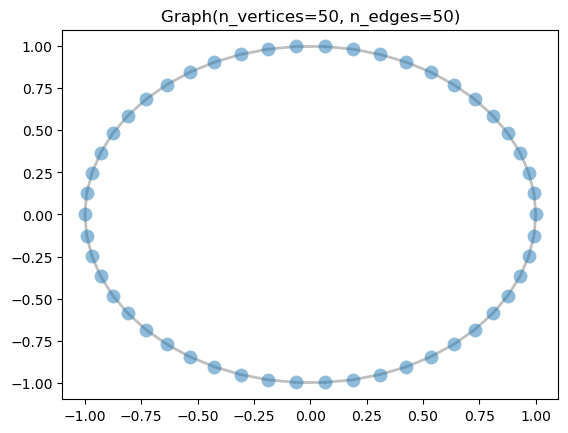

In [213]:
line_graph = get_line_graph(50)  # 50 nodes
line_graph.plot()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Grid2d(n_vertices=400, n_edges=760, N1=20, N2=20)'}>)

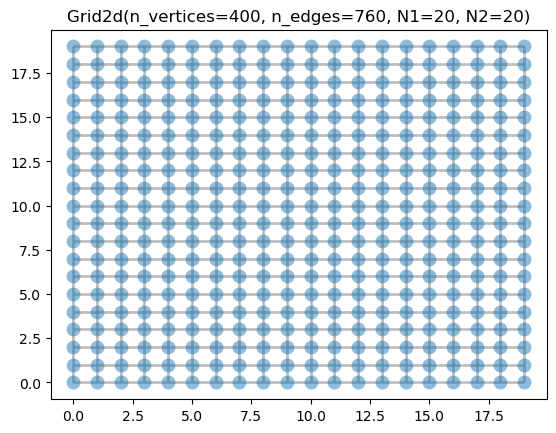

In [214]:
grid_graph = get_grid_graph(20, 20)  # 20 by 20 grid
grid_graph.plot()

We can now generate noisy signals on those two graphs.


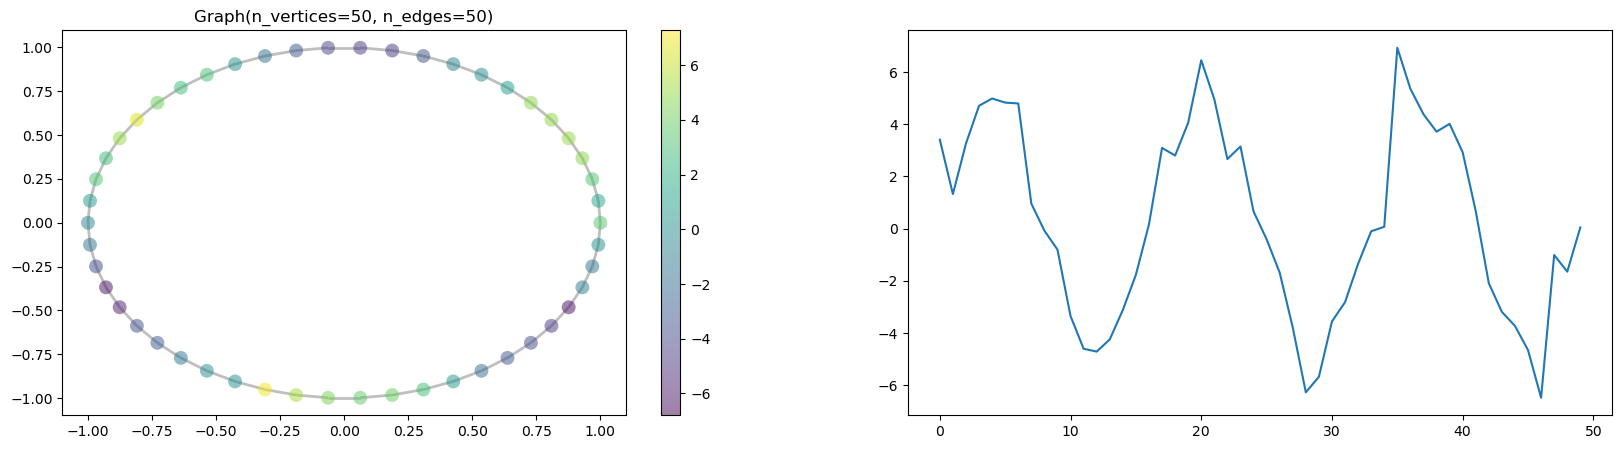

In [215]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# generate a noisy sinusoid
tt = np.linspace(0, 6 * np.pi, line_graph.N)
signal_line = 5 * np.sin(tt) + np.random.normal(size=line_graph.N)
# plot
line_graph.plot_signal(signal_line, ax=ax_0)
ax_1.plot(signal_line)

(<Figure size 2000x500 with 3 Axes>,
 <Axes: title={'center': 'Grid2d(n_vertices=400, n_edges=760, N1=20, N2=20)'}>)

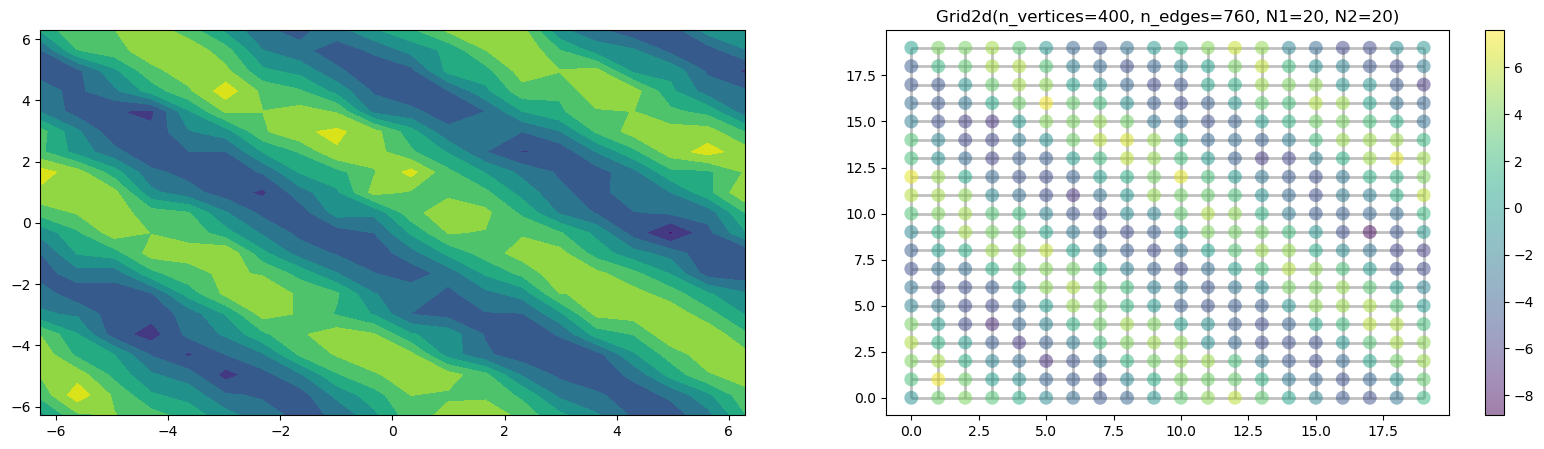

In [216]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# generate a noisy sinusoid
x = np.linspace(-2 * np.pi, 2 * np.pi, 20)
y = np.linspace(-2 * np.pi, 2 * np.pi, 20)
xx, yy = np.meshgrid(x, y, sparse=True)
z = 5 * np.sin(xx + yy)
z += np.random.normal(size=z.shape)
signal_grid = z.flatten()
# plot
ax_0.contourf(x, y, z)
grid_graph.plot_signal(signal_grid, ax=ax_1)

## Fourier basis

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Recall the definition of the Laplacian matrix.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute the Laplacian matrix for both the line graph and the grid graph.</p>
    <p>Verify your result with the Laplacian matrix provided by the <tt>Graph</tt> class (available in <tt>g.L.todense()</tt> for a graph <tt>g</tt>).</p>
</div>

In [ ]:
print(line_graph.L.todense())

**Grid graph**:

In [ ]:
print(grid_graph.L.todense())

In the GSP setting, the Fourier transform derives from the Laplacian $L$ eigendecomposition:

$$
L = U \Lambda U^T
$$

where $U$ contains (orthonormal) eigenvectors $u_i$ and $\Lambda$ is a diagonal matrix containing the eigenvalues.

For a graph signal $f$, the associated Fourier transform $\hat{f}$ is given by:

$$
\hat{f}:=U^T f.
$$

To illustre this definition, we can compute the Fourier basis on the two graph examples.

On the line graph, we compute and display the eigenvalues and the first eigenvectors.

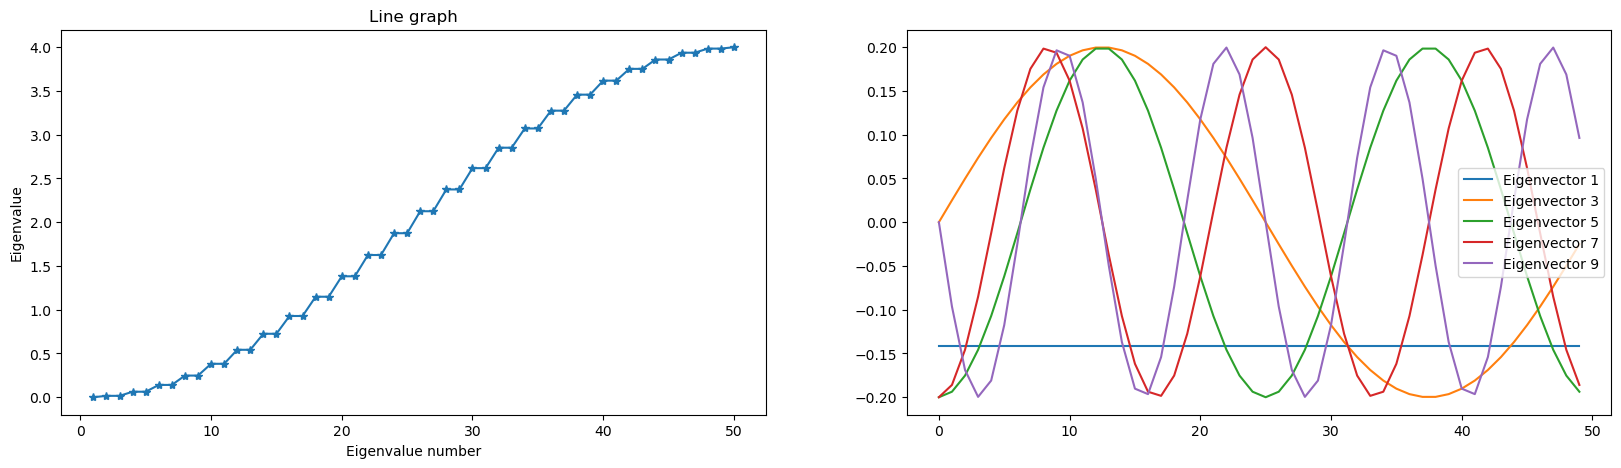

In [217]:
# Laplacian eigendecomposition
eigenvals_line, eigenvects_line = eigh(line_graph.L.todense())

fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax_0.plot(range(1, eigenvals_line.size + 1), eigenvals_line, "-*")
ax_0.set_xlabel("Eigenvalue number")
ax_0.set_ylabel("Eigenvalue")
ax_0.set_title("Line graph")

for k in range(5):
    ax_1.plot(eigenvects_line[:, 2 * k], label=f"Eigenvector {2*k+1}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe on the shape of the eigenvectors?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For the grid graph, compute and display the first and last eigenvectors.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Visually, which one the two eigenvectors is the smoothest?</p>
    <p>Recall the definition of a graph signal smoothness.</p>
</div>

$$ S(f) = f^T L f$$

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute and plot the smoothness of each eigenvector of the Laplacian (of the grid graph).</p>
    <p>What do you observe? Is this expected?</p>
</div>

## Fourier transform

Using the Fourier basis, we can now compute the Fourier transform of each signal.

In [ ]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Fourier transform
signal_line_fourier = eigenvects_line.T.dot(signal_line)
signal_grid_fourier = eigenvects_grid.T.dot(signal_grid)


# plot
ax_0.plot(abs(signal_line_fourier), "*-")
ax_0.set_title("Fourier transform (signal on the line graph)")

ax_1.plot(abs(signal_grid_fourier), "*-")
_ = ax_1.set_title("Fourier transform (signal on the grid graph)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Given the Fourier representation of a signal, how can we recover the original signal? </p>
</div>

Since there is a frequency representation, we can filter the signals, as in the classical signal processing setting. For instance, let us set to 0 all Fourier coefficients above a certain cut-off frequency.

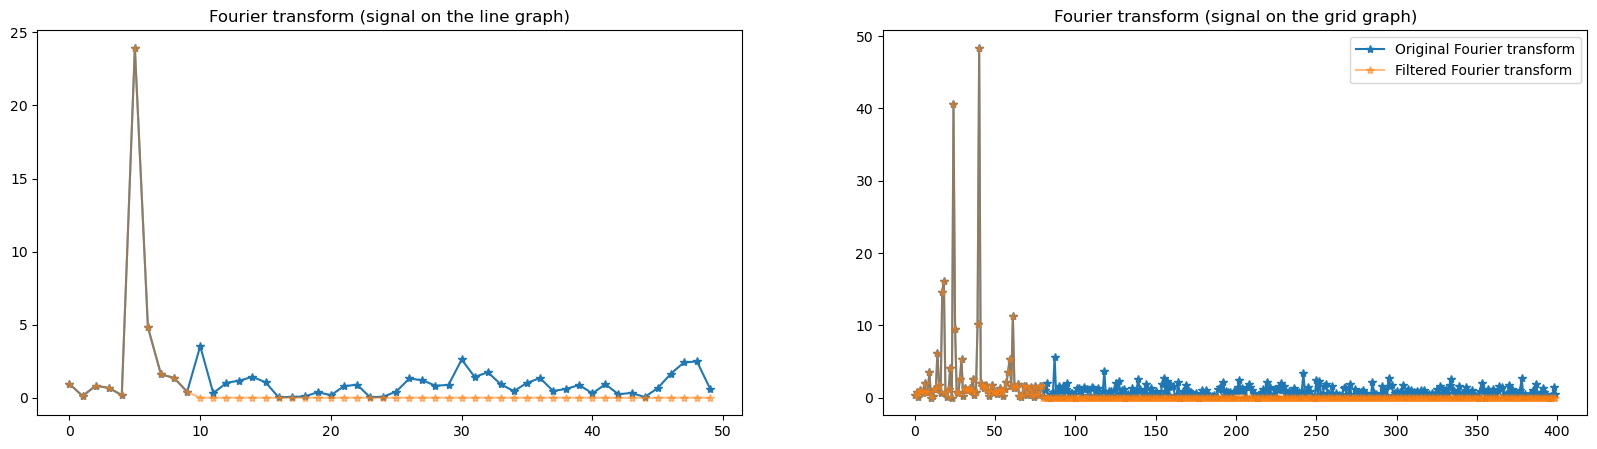

In [218]:
# we keep only 20% of the Fourier coefficients

# filtering the line graph signal
fourier_transform_filtered = np.zeros(signal_line_fourier.size)
fourier_transform_filtered[: signal_line_fourier.size // 5] = signal_line_fourier[
    : signal_line_fourier.size // 5
]
signal_line_filtered = eigenvects_line.dot(fourier_transform_filtered)
# plot
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax_0.plot(abs(signal_line_fourier), "*-", label="Original Fourier transform")
ax_0.plot(
    abs(fourier_transform_filtered),
    "*-",
    label="Filtered Fourier transform",
    alpha=0.5,
)
ax_0.set_title("Fourier transform (signal on the line graph)")

# filtering the grid graph signal
fourier_transform_filtered = np.zeros(signal_grid_fourier.size)
fourier_transform_filtered[: signal_grid_fourier.size // 5] = signal_grid_fourier[
    : signal_grid_fourier.size // 5
]
signal_grid_filtered = eigenvects_grid.dot(fourier_transform_filtered)
# plot
ax_1.plot(abs(signal_grid_fourier), "*-", label="Original Fourier transform")
ax_1.plot(
    abs(fourier_transform_filtered),
    "*-",
    label="Filtered Fourier transform",
    alpha=0.5,
)
_ = ax_1.set_title("Fourier transform (signal on the grid graph)")

_ = plt.legend()

We then reconstruct the filtered Fourier transform.

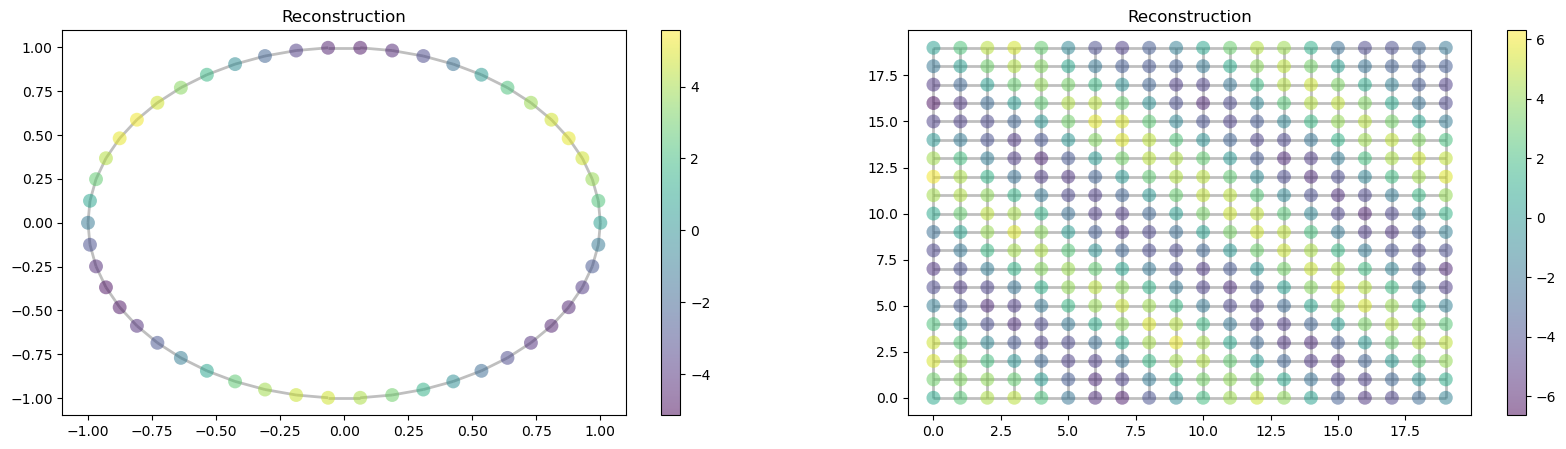

In [219]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

line_graph.plot_signal(signal_line_filtered, ax=ax_0)
ax_0.set_title("Reconstruction")
grid_graph.plot_signal(signal_grid_filtered, ax=ax_1)
_ = ax_1.set_title("Reconstruction")

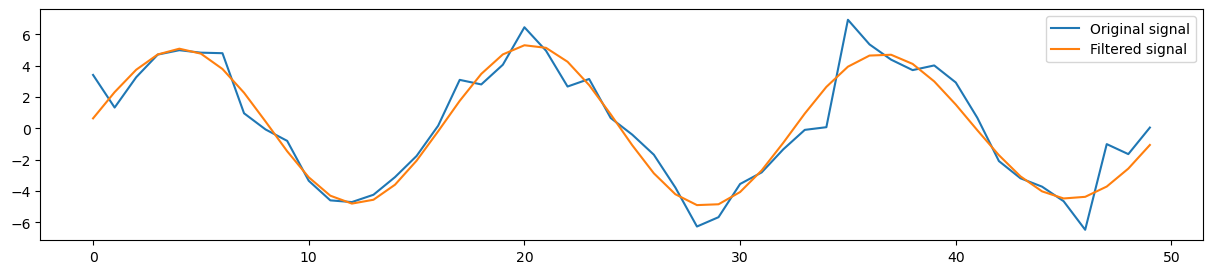

In [220]:
fig, ax = fig_ax()
ax.plot(signal_line, label="Original signal")
ax.plot(signal_line_filtered, label="Filtered signal")
_ = plt.legend()

We can use this procedure to compress signals that are supported on arbitrary graphs.

## Experiments

Let us illustrate a few GSP methods on a real-world data set.

In [221]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [222]:
# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond].reset_index().drop("index", axis="columns")

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs(CRS)

stations_gdf.head()

Numéro            Nom   Latitude  Longitude  X (Lambert II étendu)  \
0  22016001  ILE-DE-BREHAT  48.855167  -3.004500                 208083   
1  22092001        KERPERT  48.404000  -3.147667                 194096   
2  22113006       LANNAERO  48.755333  -3.468667                 173267   
3  22135001       LOUARGAT  48.551667  -3.376833                 178359   
4  22147006     MERDRIGNAC  48.182667  -2.410833                 247067   

   Y (Lambert II étendu)  Altitude                   geometry  
0                2441852        25  POINT (-3.00450 48.85517)  
1                2392507       281  POINT (-3.14767 48.40400)  
2                2433190        85  POINT (-3.46867 48.75533)  
3                2410097       148  POINT (-3.37683 48.55167)  
4                2364385       131  POINT (-2.41083 48.18267)

In [223]:
data_df.head()

numer_sta                date         date_insert      td       t      tx  \
0   29168001 2014-01-01 00:00:00 2014-01-01 00:03:54  280.35  283.65  283.75   
1   29168001 2014-01-01 01:00:00 2014-01-01 01:03:59  279.45  282.95  283.85   
2   29168001 2014-01-01 02:00:00 2014-01-01 02:04:05  280.85  283.75  283.75   
3   29168001 2014-01-01 03:00:00 2014-01-01 03:03:09  280.95  283.75  283.85   
4   29168001 2014-01-01 04:00:00 2014-01-01 04:03:14  281.15  283.55  284.05   

       tn     u    ux    un  ...       vv  etat_sol  sss    n  insolh  \
0  283.55  80.0  83.0  78.0  ...  30000.0       1.0  NaN  1.0     NaN   
1  282.95  79.0  82.0  78.0  ...      NaN       NaN  NaN  NaN     NaN   
2  282.55  82.0  84.0  80.0  ...      NaN       NaN  NaN  NaN     NaN   
3  283.65  83.0  84.0  80.0  ...  30000.0       1.0  NaN  7.0     NaN   
4  283.55  85.0  86.0  80.0  ...      NaN       NaN  NaN  NaN     NaN   

   ray_glo01     pres      pmer  station_name  temp  
0        NaN  99520.0  100490.0    PTE DU RAZ  10.5  
1        NaN  99410.0  100380.0    PTE DU RAZ   9.8  
2        NaN  99350.0  100320.0    PTE DU RAZ  10.6  
3        NaN  99230.0  100200.0    PTE DU RAZ  10.6  
4        NaN  99110.0  100080.0    PTE DU RAZ  10.4  

[5 rows x 31 columns]

Pivot the table. We now have a multivariate time serie.

In [224]:
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name         ARZAL  AURAY  BELLE ILE-LE TALUT  BIGNAN  BREST-GUIPAVAS  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3                11.3     7.1             9.7   
2014-01-01 01:00:00    9.8   10.4                10.3     7.6             9.6   
2014-01-01 02:00:00    9.7   10.0                11.2     7.7             9.1   
2014-01-01 03:00:00    9.4   10.4                11.4     7.9             9.7   
2014-01-01 04:00:00    9.8   10.8                11.4     8.8             9.8   

station_name         BRIGNOGAN  DINARD  GUERANDE  ILE DE GROIX  ILE-DE-BREHAT  \
date                                                                            
2014-01-01 00:00:00        NaN     6.8      10.4           9.0            7.0   
2014-01-01 01:00:00        9.2     6.5      10.6          10.0            7.0   
2014-01-01 02:00:00        9.4     6.5      10.2           9.5            7.8   
2014-01-01 03:00:00       10.1     7.1      10.6          10.4            8.3   
2014-01-01 04:00:00       10.2     7.6      10.6          10.8            8.9   

station_name         ...  SAINT-CAST-LE-G  SARZEAU SA  SIBIRIL S A  SIZUN  \
date                 ...                                                    
2014-01-01 00:00:00  ...              6.1         9.8          7.4    8.5   
2014-01-01 01:00:00  ...              6.3         9.9          8.2    8.3   
2014-01-01 02:00:00  ...              6.4         9.2          8.5    8.5   
2014-01-01 03:00:00  ...              7.0        10.1          8.5    8.7   
2014-01-01 04:00:00  ...              7.7        10.5          9.1    9.1   

station_name         SPEZET  ST BRIEUC  ST NAZAIRE-MONTOIR  ST-SEGAL S A  \
date                                                                       
2014-01-01 00:00:00     8.3        7.5                 9.0           9.0   
2014-01-01 01:00:00     8.6        7.0                 9.1           9.5   
2014-01-01 02:00:00     8.6        7.5                 9.5           9.4   
2014-01-01 03:00:00     8.9        7.2                 9.0           9.9   
2014-01-01 04:00:00     9.4        7.6                 9.5          10.0   

station_name         THEIX  VANNES-SENE  
date                                     
2014-01-01 00:00:00    9.3          9.7  
2014-01-01 01:00:00    9.1          9.9  
2014-01-01 02:00:00    9.4          9.6  
2014-01-01 03:00:00    8.9          9.8  
2014-01-01 04:00:00    9.6         10.2  

[5 rows x 43 columns]

Plot the position of the grounds stations on a map.

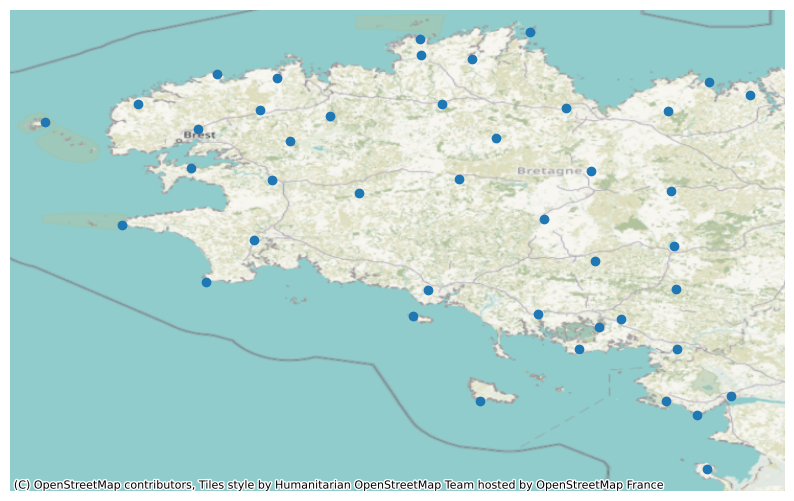

In [225]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

### Data exploration

We can start by checking for some malfunctions in the stations. To that end, we simply count the number of NaNs.

In [226]:
temperature_df.isna().sum(axis=0).sort_values(ascending=False).head()

station_name
ST NAZAIRE-MONTOIR    70
LANNAERO              37
PLOUDALMEZEAU          2
SIZUN                  1
QUIMPER                1
dtype: int64

After this, we can look at the (geodesic) distance between stations.

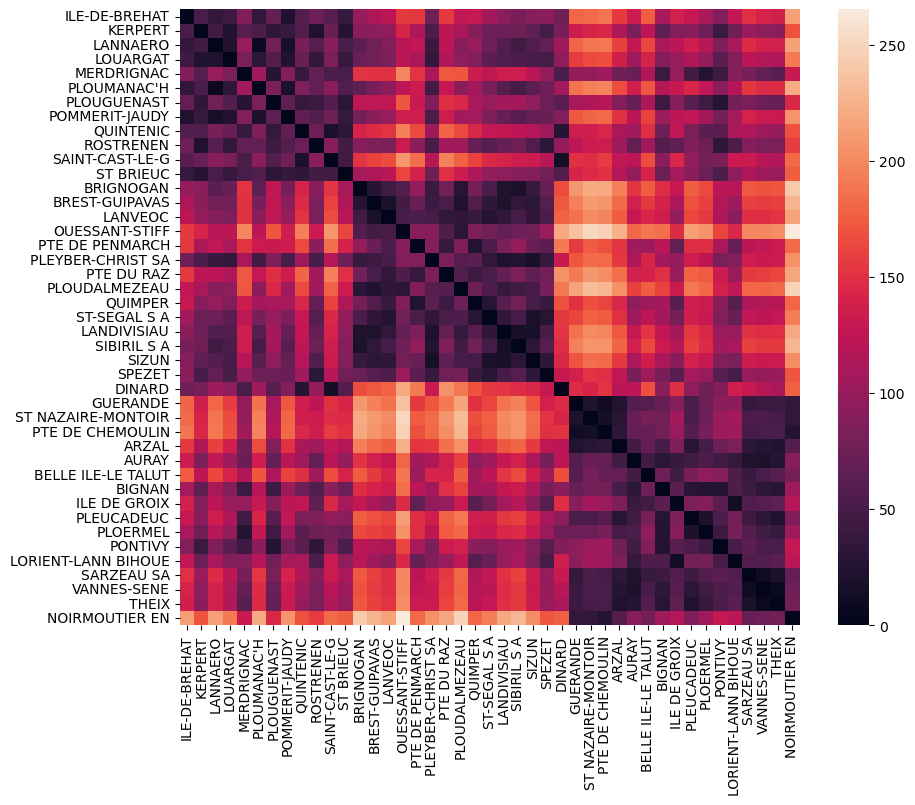

In [227]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax(figsize=(10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the two closest stations?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the two most distant stations?</p>
</div>

We can plot the temperature evolution for the two closest stations.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the temperature evolution for the two closest stations.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same for the two most distant stations.</p>
</div>

### Graph construction

This network of sensors can be modeled as a graph, and the temperature signal, as a serie of graph signals.

To that end, we need to define a graph.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Give two ways to derive an adjacency matrix from a distance matrix?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> The number of connected components of a graph is the multiplicity of the eigenvalue 0 of the Laplacian matrix. Can you explain why? Write a function `is_connected` which returns True if the input graph is connected and False otherwise.</p>
</div>

In [228]:
def is_connected(graph) -> bool:
    pass

#### Distance-based weigthless graph

In [229]:
threshold = 1  # km
adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
G = graphs.Graph(adjacency_matrix)
print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

The graph is not connected, with 43 nodes, 0 edges


/Users/valerio/anaconda3/lib/python3.10/site-packages/pygsp/plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Graph(n_vertices=43, n_edges=0)'}>)

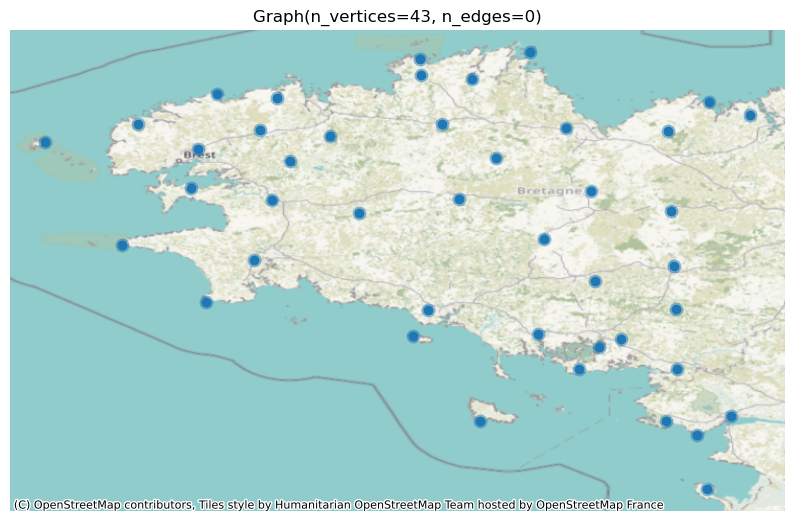

In [230]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Plot the number of edges with respect to the threshold.</p>
    <p>What is approximatively the lowest threshold possible in order to have a connected graph?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Plot the average degree with respect to the threshold.</p>
</div>

#### Distance-based weighted graph

Each vertex can be connected to other vertices by edges weighted by a Gaussian kernel:
$$
W_{ij} = \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right) \quad\text{if}\quad \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right)>\lambda,\ 0\ \text{otherwise}
$$
where the $c_i$ are the station positions, $\sigma$ is the so-called bandwidth parameter, and $\lambda>0$ is a threshold. 

In [ ]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.85
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not is_connected(G_gaussian) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> What is the influence of the threshold.</p>
    <p>Choose an appropriate value for the threshold.</p>
</div>

#### Correlation graph

The correlation between the signals can also define a graph.

In [ ]:
_ = sns.heatmap(temperature_df.corr())

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Describe how to create a graph using the signal correlation. Code it.</p>
</div>

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_corr.set_coordinates(stations_np)
G_corr.plot(ax=ax)

Note that stations that are very far apart can be connected. This unveils a different structure.

### Graph signal processing

In this section, we set the graph to the one that comes from the Gaussian kernel.

#### Signal smoothness

Let us study the signal smoothness, at each hour of measure.

In [231]:
# drop the NaNs
temperature_df_no_nan = temperature_df.dropna(axis=0, how="any")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute the smoothness for a specific hour of measure.</p>
</div>

In [232]:
# choose a specific hour
choosen_hour = pd.to_datetime("2014-01-01 01:00:00")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Display the smoothess evolution with time.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Show the state of the network, when the signal is the smoothest.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same, when the signal is the least smooth.</p>
</div>